In [1]:
import os
import pickle
import sys
import time
from inspect import signature
from queue import Queue
from threading import Event
from typing import Tuple

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tritonclient.grpc as triton
from gwpy.frequencyseries import FrequencySeries
from gwpy.timeseries import TimeSeries, TimeSeriesDict
from rich.progress import Progress
from scipy import signal

from deepcleaner import utils as dcu
from deepcleaner.pipeline import main as pipeline
from hermes.typeo import typeo

%matplotlib inline

In [2]:
# don't mind this, just a quick hack to easily
# get the arguments I call the cleaning script with
def f(**kwargs):
    return kwargs
f.__signature__ = signature(pipeline)
sys.argv = [None, "--typeo", ":deepclean"]
config = typeo(f)()

# I'll replace a coupel procedural params
# that will make running things here easier
config["num_frames"] = 100
config["inference_rate"] = 500
config

{'witness_data_dir': '/home/muhammed.saleem/deepClean/automated-offline/o3replay_unofficial/live/lldetchar/H1',
 'strain_data_dir': '/home/muhammed.saleem/deepClean/automated-offline/o3replay_unofficial/live/llhoft/H1',
 'write_dir': '/home/alec.gunny/frames/deepcleaned/aggregated-0.5s',
 'kernel_length': 1.0,
 'stride_length': 0.001953125,
 'sample_rate': 4096.0,
 'inference_rate': 500,
 'channels': 'channels.txt',
 'preprocess_pkl': 'ppr.bin',
 'sequence_id': 1001,
 'url': 'localhost:8001',
 'model_name': 'deepclean-stream',
 'model_version': 1,
 'max_latency': 0.5,
 'num_frames': 100,
 'start_first': True,
 'timeout': 3.0,
 'log_file': 'deepclean.latency-0.5.log',
 'verbose': True}

In [3]:
# define some useful parameters for how to break up our data
throw_away = config["max_latency"] // config["stride_length"]
stride_size = int(config["sample_rate"] * config["stride_length"])
kernel_size = int(config["sample_rate"] * config["kernel_length"])

# load in some additional files we'll need
with open(config["channels"], "r") as f:
    channels = [i for i in f.read().splitlines() if i]

with open(config["preprocess_pkl"], "rb") as f:
    preproc_config = pickle.load(f)

# set up our preprocessing parameters
low = preproc_config["filt_fl"][0] * 2 / config["sample_rate"]
high = preproc_config["filt_fh"][0] * 2 / config["sample_rate"]
sos = signal.butter(
    preproc_config["filt_order"],
    [low, high],
    btype="bandpass",
    output="sos"
)

# reorder the preprocessing parameters to
# align with the network's channel ordering
mean, scale = [], []
for i, channel in enumerate(sorted(channels)):
    if channel == channels[0]:
        strain_mean = preproc_config["mean"][i]
        strain_scale = preproc_config["std"][i]
    else:
        mean.append(preproc_config["mean"][i])
        scale.append(preproc_config["std"][i])

mean = np.array(mean).astype("float32")
scale = np.array(scale).astype("float32")

# initialize a triton client for communicating
# with the inference service
client = triton.InferenceServerClient(config["url"])

Define a couple utility functions

In [4]:
def load_data(fname: str) -> Tuple[np.ndarray, np.ndarray]:
    """Load the strain and witness data for a given frame file

    Args:
        fname:
            The name of the frame file in the witness
            data directory. The name of corresponding
            file in the strain directory will be obtained
            by substituting 'Detchar' with 'HOFT' in
            the filename.
    Returns:
        1-D strain data numpy array
        2-D preprocessed witness data numpy array
    """

    # read the witness data frame file
    witness_fname = os.path.join(config["witness_data_dir"], fname)
    witness_dict = TimeSeriesDict.read(witness_fname, channels[1:])

    # preprocess it by resampling, stacking into an array,
    # then centering the data per-channel
    witnesses = []
    for channel in sorted(channels):
        if channel == channels[0]:
            # ignore strain channel
            continue

        witness = witness_dict[channel]
        if witness.sample_rate.value != config["sample_rate"]:
            witness.resample(config["sample_rate"])
        witnesses.append(witness.value)

    witnesses = np.stack(witnesses).astype("float32")[None]
    witnesses = (witnesses - mean) / scale

    # load the strain data and just add it
    # to our running array keeping track of that
    strain_fname = os.path.join(
        config["strain_data_dir"], fname.replace("Detchar", "HOFT")
    )
    strain = TimeSeries.read(strain_fname, channels[0])
    if strain.sample_rate.value != config["sample_rate"]:
        strain.resample(config["sample_rate"])[0]

    return strain, witnesses


def get_asd(ts: np.ndarray) -> FrequencySeries:
    ts = TimeSeries(ts, sample_rate=config["sample_rate"])
    asd = ts.asd(fftlength=10, overlap=0.5, method="median")
    return asd.crop(20, 300)

Start by doing the fully offline inference on these frames.

In [5]:
client = triton.InferenceServerClient(config["url"])
dc_metadata = client.get_model_metadata("deepclean")
offline_input = triton.InferInput(
    name=dc_metadata.inputs[0].name,
    shape=dc_metadata.inputs[0].shape,
    datatype=dc_metadata.inputs[0].datatype
)

# do inference on one frame more than we need
# so that we can properly average everything
fnames = os.listdir(config["witness_data_dir"])[:config["num_frames"] + 1]
updates_per_frame = int(config["sample_rate"] // stride_size)
total_updates = updates_per_frame * len(fnames)

noise_predictions = []
with Progress() as progress:
    task_id = progress.add_task("Sending requests", total=total_updates)

    # load in data up front since we'll immediately
    # need the next frame as soon as we take a step
    strain, witnesses = load_data(fnames[0])
    for n, fname in enumerate(fnames[1:]):
        frame_strain, frame_witnesses = load_data(fname)

        witnesses = np.append(witnesses, frame_witnesses, axis=-1)
        if n < len(fnames):
            # ignore thet last strain, since we're not
            # actually planning on cleaning it
            strain = np.append(strain, frame_strain)

        for i in range(updates_per_frame):
            # slice out the current stretch of witness
            # data and encode it into our input
            # protobuf message
            start = i * stride_size
            stop = start + kernel_size
            kernel = witnesses[:, :, start:stop]
            offline_input.set_data_from_numpy(kernel)

            # make synchronous requests to the server
            # to keep the implementation simple
            response = client.infer(
                "deepclean",
                model_version=str(config["model_version"]),
                inputs=[offline_input]
            )

            # parse the numpy array of our inference
            # output from the server response
            noise = response.as_numpy(dc_metadata.outputs[0].name)
            noise_predictions.append(noise)

            # update our progress bar and sleep for longer
            # than we would in the real pipeline because
            # our data size is so much larger per-request
            progress.update(task_id, advance=1)
            time.sleep(2 / config["inference_rate"])

        # slough off old data to keep memory under control
        witnesses = witnesses[:, :, kernel_size:]

Output()

Sending requests ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸  99% 0:00:04

Postprocess these model predictions to produce cleaned strain.

In [6]:
# bandpass filter the strain
offline_strain = signal.sosfiltfilt(sos, strain)

# now make an empty array for our noise predictions
# and fill it with averages of overlapping windows
offline_noise_prediction = np.zeros_like(offline_strain)
for i in range(total_updates - updates_per_frame - 1):
    # first few predictions don't get as many
    # overlapping windows, so scale them accordingly
    factor = max(1 / (i + 1), stride_size / kernel_size)

    start = i * stride_size
    stop = start + kernel_size
    offline_noise_prediction[start: stop] = noise_predictions[i] * factor

# postprocess the noise predictions by
# uncentering and bandpass filtering
offline_noise_prediction = strain_mean + strain_scale * offline_noise_prediction
offline_noise_prediction = signal.sosfiltfilt(sos, offline_noise_prediction)

offline_cleaned = offline_strain - offline_noise_prediction

Let's take a preview of the ASD of the offline data here

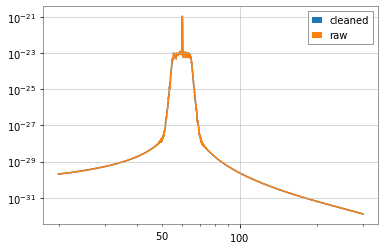

In [7]:
fig, ax = plt.subplots()

ax.loglog(get_asd(offline_cleaned), label="cleaned")
ax.loglog(get_asd(offline_strain), label="raw")
ax.legend()
fig.show()

# Online predictions
Now we'll do the same inference using an online pipeline. The key difference here is that we have to make our predictions at least somewhat causally. We can take small peeks into the future at the expense of some latency, but we can't wait around for e.g. multiple seconds to make our predictions better. This means we:
- Can't (or at least won't) do a full averaging over all `sample_rate/stride_size` frames overlapping any particular stride of data, since this would mean incurring an extra full second of latency. For this model, we've capped out latency at 0.5s, so we'll "only" average over `sample_rate/(2 * stride_size)` = 1024 frames.
    - Note that this is handled on the server end by an "aggregator" model, so we don't need to do any averaging in our client pipeline.
- Can't bandpass filter across stretches encompassing future data. This means that our filtered frames will fall at the edge of the segments to which the filter is applied, which may lead to some artifacts. We _can_, at the expense of memory and probably some processing time however, include past data in our filters, which should help improve the quality a bit.

To recreate the asynchronous pipeline we're using in production, we need to do streaming inference using Triton, which reduces our I/O overhead to and from the inference service. To make sure our streams always update the same snapshotter state, Triton insists that we do inference _asynchronously_ and define a callback function that it can use to handle responses from the server in a separate thread.

We'll define a simple callback function below that will just add the predictions to a list we'll postprocess later, but in a way that looks like the online postprocessing. The other key thing we do in the callback is throw away our first few predictions, since those will correspond to predictions for times _before_ the start of the data stream (working on a visualization to illustrate this).

In [8]:
# start by similarly creating a protobuf input for the
# streaming model. Note that the last dimension of this
# input is only equal to `stride_size` rather than `kernel_size`
metadata = client.get_model_metadata(config["model_name"])
assert metadata.inputs[0].shape[-1] == stride_size
online_input = triton.InferInput(
    name=metadata.inputs[0].name,
    shape=metadata.inputs[0].shape,
    datatype=metadata.inputs[0].datatype
)

# let's take a look at what this metadata
# looks like for reference
metadata

name: "deepclean-stream"
versions: "1"
platform: "ensemble"
inputs {
  name: "stream"
  datatype: "FP32"
  shape: 1
  shape: 21
  shape: 8
}
outputs {
  name: "aggregator"
  datatype: "FP32"
  shape: 1
  shape: 8
}

In [9]:
noise_predictions = []
error_queue = Queue()
stop_event = Event()

def callback(result, error=None):
    """Simplified version of our real callback function"""

    # make sure nothing went wrong on the server
    if error is not None and not stop_event.is_set():
        stop_event.set()
        error_queue.put(str(error))
    elif stop_event.is_set():
        # if the stop event got set, something already
        # went wrong on the server, and there's no
        # point in catching the same error over and over
        return

    request_id = int(result.get_response().id)

    # we need to get rid of our first few inferences
    # since they technically correspond to predictions
    # from the before the first frame starts!
    if request_id < throw_away:
        return

    # parse and record the server's response
    prediction = result.as_numpy(metadata.outputs[0].name)[0]
    noise_predictions.append(prediction)

Now we're ready to do inference. We'll load in one frame at a time, then iterate through each frame in `stride_size`'d chunks which will update the snapshot state on the server.

In [10]:
# open a gRPC streaming connection to the server
with client, Progress() as progress:
    client.start_stream(callback=callback)
    task_id = progress.add_task("Sending requests", total=total_updates)

    for n, fname in enumerate(fnames):
        # we don't need the strain this time
        _, witnesses = load_data(fname)

        # send `stride_size`'d updates to the snapshot
        # model on the server
        for i in range(updates_per_frame):

            # check to make sure everything is still
            # ok on the server
            if stop_event.is_set():
                err = error_queue.get_nowait()
                raise RuntimeError(err)

            # update the input protobuf with the new data
            start = i * stride_size
            stop = (i + 1) * stride_size
            update = witnesses[:, :, start:stop]
            online_input.set_data_from_numpy(update)

            # make an asynchronous request using the
            # current update
            request_id = n * updates_per_frame + i
            client.async_stream_infer(
                config["model_name"],
                model_version=str(config["model_version"]),
                inputs=[online_input],
                request_id=str(request_id),
                sequence_id=config["sequence_id"],
                sequence_start=request_id == 0,
                sequence_end=request_id == total_updates - 1
            )

            # sleep to keep from overwhelming the network
            progress.update(task_id, advance=1)
            time.sleep(1 / config["inference_rate"])

noise_predictions = np.concatenate(noise_predictions)

Output()

Sending requests ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

In contrast to the offline postprocessing, we need to do filtering and subtraction on a frame-by-frame basis, though we can include _past_ data for each one of our frames.

In [11]:
online_cleaned = np.array([])
for i in range(config["num_frames"]):
    start = i * int(config["sample_rate"])
    stop = (i + 1) * int(config["sample_rate"])

    # grab the predictions that would correspond
    # to this frame
    # frame_noise_prediction = noise_predictions[start: stop]
    # frame_noise_prediction = strain_mean + strain_scale * frame_noise_prediction
    # frame_noise_prediction = signal.sosfiltfilt(sos, frame_noise_prediction)

    # rather than doing things on a frame-by-frame basis,
    # which tends to be noisy, we can at least filter by
    # using all _past_ data for any individual frame
    online_noise = noise_predictions[:stop]
    online_noise = strain_mean + strain_scale * online_noise
    online_noise = signal.sosfiltfilt(sos, online_noise)
    online_strain = signal.sosfiltfilt(sos, strain[:stop])

    # now slice off the data for just this frame and
    # subtract to produce this cleaned frame
    online_strain, online_noise = online_strain[start:], online_noise[start:]
    clean = online_strain - online_noise

    # add this cleaned frame to our running total
    online_cleaned = np.append(online_cleaned, clean)

Let's take a look at how this online cleaned data compares to the raw and offline cleaned.

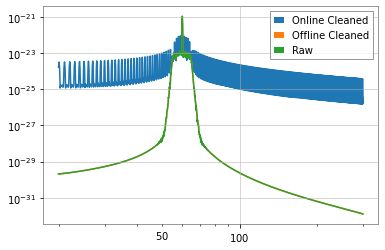

In [12]:
fig, ax = plt.subplots()

ax.loglog(get_asd(online_cleaned), label="Online Cleaned")
ax.loglog(get_asd(offline_cleaned), label="Offline Cleaned")
ax.loglog(get_asd(offline_strain), label="Raw")

ax.legend()
fig.show()

So substantially worse. So first thing's first, let's make sure that the predictions being returned by the server aren't causing the problem by cleaning those results in an offline fashion. Note that we shouldn't expect these results to match up perfectly with the fully offline results, because the amount of frame-by-frame averaging is different.

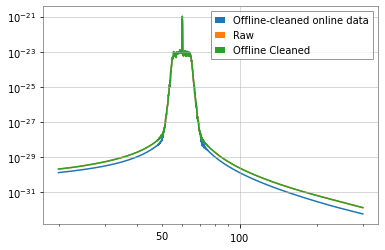

In [13]:
uncentered = strain_mean + strain_scale * noise_predictions
uncentered = signal.sosfiltfilt(sos, uncentered)

stop = int(config["sample_rate"] * config["num_frames"])
pseudo_online_cleaned = offline_strain[:stop] - uncentered[:stop]

fig, ax = plt.subplots()
ax.loglog(get_asd(pseudo_online_cleaned), label="Offline-cleaned online data")
ax.loglog(get_asd(offline_strain), label="Raw")
ax.loglog(get_asd(offline_cleaned), label="Offline Cleaned")

ax.legend()
fig.show()

Good to get some confirmation that our IaaS implementation is doing things correctly.

The next thing that pops into my mind is that while we can't look _indefinitely_ into the future to do filtering in the online implementation, we can at least look `max_latency` seconds into the future, since we've already waited around that long for our averaged predictions anyway. Maybe including this extra bit of data will preclude some of the edge effects we're seeing.

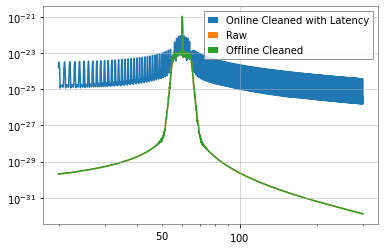

In [14]:
online_plus_latency_cleaned = np.array([])
extra = int(config["sample_rate"] * config["max_latency"])
for i in range(config["num_frames"]):
    start = i * int(config["sample_rate"])
    stop = (i + 1) * int(config["sample_rate"])

    # grab a bit of future data as well for the purposes of filtering
    online_noise = noise_predictions[:stop + extra]
    online_noise = strain_mean + strain_scale * online_noise
    online_noise = signal.sosfiltfilt(sos, online_noise)
    online_strain = signal.sosfiltfilt(sos, strain[:stop + extra])

    # but slice off just the data for this frame
    online_strain, noise = online_strain[start:stop], noise[start:stop]
    clean = online_strain - noise

    # add this cleaned frame to our running total
    online_plus_latency_cleaned = np.append(online_cleaned, clean)

fig, ax = plt.subplots()
ax.loglog(get_asd(online_plus_latency_cleaned), label="Online Cleaned with Latency")
ax.loglog(get_asd(offline_strain), label="Raw")
ax.loglog(get_asd(offline_cleaned), label="Offline Cleaned")

ax.legend()
fig.show()

Ok not much better. My suspicion is that the issue is that there's nothing enforcing good continuity between the samples at the edges of subsequent frames, so when we append them to one another naively this introduces artifacts. One test of this might be to compute the ASD of each individual frame, then take a look at their median.

I don't expect this to look as good as the fully offline ASD due to the small window over which each ASD is being computed, but I expect it to look better than the ASD computed over the full online time series.

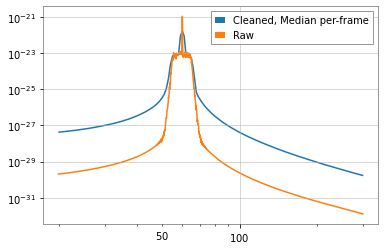

In [15]:
# split the cleaned data into individual frames and
# compute the asd for each frame
asds = []
for frame in np.split(online_cleaned, config["num_frames"]):
    ts = TimeSeries(frame, sample_rate=config["sample_rate"])
    asd = ts.asd().crop(20, 300)
    asds.append(asd)

# compute the median at each frequency across all frames
cleaned_asd = np.stack(asds).median(axis=0)

fig, ax = plt.subplots()
ax.loglog(cleaned_asd, label="Cleaned, Median per-frame")
ax.loglog(get_asd(offline_strain), label="Raw")
ax.legend()
fig.show()

This aligns decently well with what I think I would expect given the hypothesis above, but not quite sure where to go from here.